# Investigating Fake News on Facebook

In [7]:
import import_ipynb
import math
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns # for visualiation
import matplotlib.pyplot as plt # plotting
import matplotlib
import warnings
warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')
%matplotlib inline
import altair as alt
alt.renderers.enable('notebook')

df = pd.read_csv('./facebook_with_reactions.csv')
outcomes = df[['Rating']]

## drop useless columns 
df = df.drop(columns=['Debate', 'status_link', 'permalink_url', 'Post URL', 
                      'status_message', 'link_name', 'share_count', 'Unnamed: 0', 'account_id',
                      'status_id', 'status_type', 'status_published', 'post_id', 'reaction_count', 'Date Published'])

# new columns
df['Popular'] = df.num_comments + df.num_likes + df.num_shares

## change Rating to numeric for classification
df['Rating'] = df.Rating.replace(['mostly false', 'no factual content', 'mixture of true and false', 'mostly true'], [0,1,2,3])
df['Rating2'] = df.Rating.replace([0,1,2,3], [0,0,0,1]).astype(int)

## remove spaces in columns
df.columns = [c.replace(' ', '_') for c in df.columns]

# get dummy variables for categorical columns
df = pd.get_dummies(df)

In [8]:
from sklearn.model_selection import train_test_split

# train and test data that uses 4 categories for Ranking (our outcome variable)
tr_feat, test_feat, tr_out, test_out = train_test_split(
   df.drop(columns=['Rating', 'Rating2']),      # features
   df.Rating,    # outcome
   random_state=0,
   test_size=0.20, # percentage of data to use as the test set
   
)

# train and test data that uses 2 categories for outcome variable
tr2_feat, test2_feat, tr2_out, test2_out = train_test_split(
   df.drop(columns=['Rating', 'Rating2']),      # features
   df.Rating2,    # outcome
   random_state=0,
   test_size=0.20, # percentage of data to use as the test set
   
)

## Purpose

The purpose of this Notebook is to demonstrate the process we went through to answer our research question. We wanted to explore Facebook post popularity and its relationship with Fake News. Specifically, we wanted to know if there was a relationship between popularity and Fake News and take that a step further and see if we can predict if something is misinformation based on its popularity in addition to some other factors. 

## Exploratory Data Analysis

- add visulizations

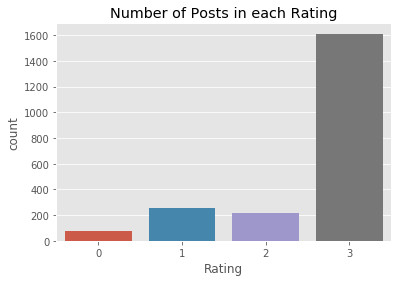

In [9]:
ax = sns.countplot(df.Rating)
ax.set_title('Number of Posts in each Rating');

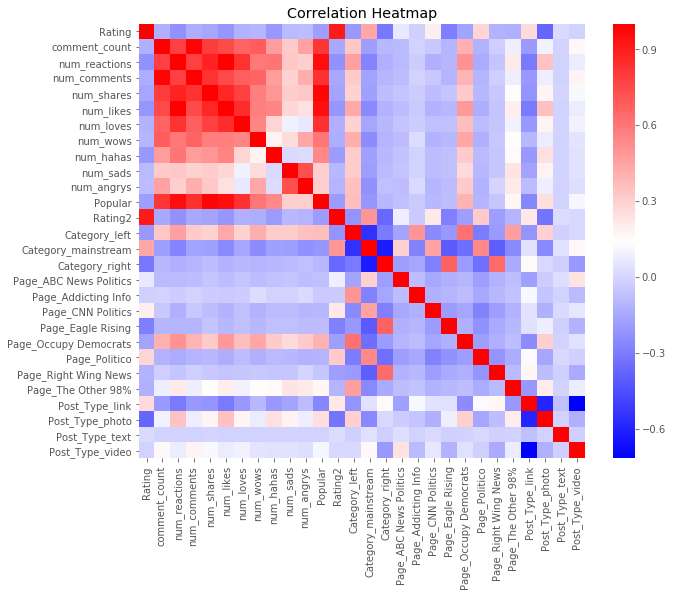

In [10]:
plt.figure(figsize = (10,8))
corr = df.corr()
ax = plt.axes()
ax.set_title('Correlation Heatmap')
sns.heatmap(corr, cmap='bwr', ax = ax,
        xticklabels=corr.columns,
        yticklabels=corr.columns);

In [11]:
# plot that shows counts of ratings colored based on the type of post i.e. video, link, text, etc.
alt.Chart(df).mark_bar(size=50).encode(
    x='Rating',
    y='count()',
    color='Post_Type'
).properties(width=300, height=300, title='Rating by Post Type')

ValueError: Post_Type encoding field is specified without a type; the type cannot be inferred because it does not match any column in the data.

Chart({
  data:       Rating  comment_count  num_reactions  num_comments  num_shares  \
  0          1           15.0            145            14           0   
  1          3           34.0             29            32           0   
  2          3           27.0             61            24          34   
  3          3           86.0            163            80          33   
  4          3         2815.0           3156          2779         556   
  5          3           21.0             28            19          23   
  6          3          105.0            399           103          44   
  7          3           64.0             59            59           7   
  8          3            6.0             39             5           7   
  9          3           59.0            273            54         147   
  10         3           14.0             28            14           8   
  11         3            0.0             10             0           0   
  12         3          

In [12]:
alt.Chart(df).mark_bar(size=50).encode(
    x='Category',
    y='count()',
    color='Page'
).properties(width=300, height=300, title='Category by Page')

ValueError: Page encoding field is specified without a type; the type cannot be inferred because it does not match any column in the data.

Chart({
  data:       Rating  comment_count  num_reactions  num_comments  num_shares  \
  0          1           15.0            145            14           0   
  1          3           34.0             29            32           0   
  2          3           27.0             61            24          34   
  3          3           86.0            163            80          33   
  4          3         2815.0           3156          2779         556   
  5          3           21.0             28            19          23   
  6          3          105.0            399           103          44   
  7          3           64.0             59            59           7   
  8          3            6.0             39             5           7   
  9          3           59.0            273            54         147   
  10         3           14.0             28            14           8   
  11         3            0.0             10             0           0   
  12         3          

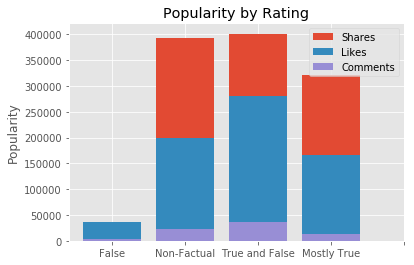

In [13]:
p1 = plt.bar(df.Rating, df.num_shares)
p2 = plt.bar(df.Rating, df.num_likes)
p3 = plt.bar(df.Rating, df.num_comments)

ind = np.arange(5)

plt.ylabel('Popularity')
plt.title('Popularity by Rating')

plt.xticks(ind, ('False', 'Non-Factual', 'True and False', 'Mostly True'))

plt.legend((p1[0], p2[0], p3[0]), ('Shares', 'Likes', 'Comments'))

plt.show()

## Feature Engineering and Selection

### Statistical Analysis 

In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='sag',
                         multi_class='multinomial').fit(tr_feat, tr_out)

clf2 = LogisticRegression(random_state=0, solver='sag',
                         multi_class='multinomial').fit(tr2_feat, tr2_out)

print('accuracy using 2 outcome categories: ' + str(round(clf2.score(test2_feat, test2_out), 2))
     + '\naccuracy using 4 outcome categories: ' + str(round(clf.score(test_feat, test_out), 2)))

accuracy using 2 outcome categories: 0.78
accuracy using 4 outcome categories: 0.74


In [15]:
from sklearn.metrics import classification_report
tar = ['mostly false', 'no factual content', 'mixture of true and false', 'mostly true']

pred = clf.predict(test_feat)
print('Using four classes:\n')
print(classification_report(test_out, pred, target_names=tar))

print('-------------------------------------------------------------------\n')
print('Using two classes:\n')
pred = clf2.predict(test2_feat)
print(classification_report(test2_out, pred, target_names=['False', 'True']))

Using four classes:

                           precision    recall  f1-score   support

             mostly false       0.00      0.00      0.00        15
       no factual content       0.61      0.22      0.33        63
mixture of true and false       0.30      0.07      0.12        42
              mostly true       0.76      0.97      0.86       314

              avg / total       0.67      0.74      0.68       434

-------------------------------------------------------------------

Using two classes:

             precision    recall  f1-score   support

      False       0.69      0.35      0.46       120
       True       0.79      0.94      0.86       314

avg / total       0.76      0.78      0.75       434



## Machine Learning Models

In [ ]:
## use selectkbest to get the best features

### KNN Classifier
- Justin

In [16]:
import KNN as k;

importing Jupyter notebook from KNN.ipynb


In [23]:
cols = list(tr2_feat.columns.values)
features = []
for bool, feature in zip(k.rfe.support_, cols):
    if bool:
        features.append(feature)
knn_train_features = tr2_feat[features]
knn_test_features = test2_feat[features]

In [24]:
k.knn_grid.fit(knn_train_features, tr2_out)
k.knn_grid.score(knn_test_features, test2_out)

0.8064516129032258

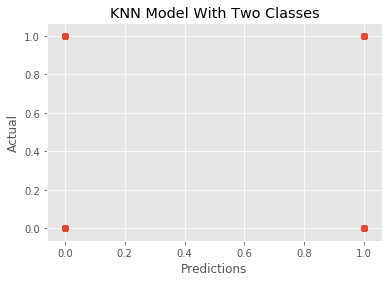

In [25]:
plt.title('KNN Model With Two Classes')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.scatter(k.knn_grid.predict(knn_test_features), test2_out)

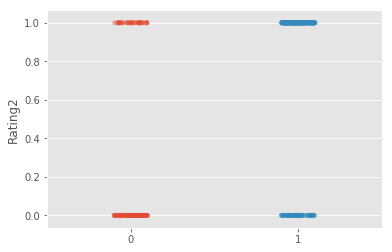

In [34]:
sns.stripplot(x=k.knn_grid.predict(knn_test_features), y=test2_out, jitter=True, dodge=True, alpha=0.5)

### Random Forest Classifier
- Connie 

### Multi-layer Perceptron
- For the MLP classifier, we defined several parameters within a GridSearch to select the best MLP model. These parameters included `activation`, `learning_rate`, `hidden_layer_sizes`, and the `solver`. We set the activation to choose between relu and logistic because these are able to converge the fastest and generally give good predictions for smaller data sets. We wanted adaptive learning to see if the model could pick up on any complex changes in the sampling of data. We also let the model choose between a couple solvers that we saw provided the highest scores. As for the hidden layer sizes, they roughly follow the width of our data and seemed to perform better than other iterations of the model. We also made sure the MLP classifier shuffled samples and used cross validation to ensure accuracy. For feature selection, we decided to use _Select K Best_ with the `f_classif` solver and wanted anywhere from 5 to 25 (the width of our data) features. Before the model is ran we also used a Robust Scaler for data normalization and used the default (25, 75) or Inter-Quartile Range parameter. Shown below, we can see the results generated from this model. 

In [ ]:
import MLP as m;
clf = m.mlp.fit(tr_feat, tr_out)
clf2 = m.mlp.fit(tr2_feat, tr2_out)

clf.score(test_feat, test_out)

In [ ]:
plt.title('MLP Model With Four Classes')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.scatter(mlp_4class.predict(test2_feat), test2_out)

In [ ]:
clf2.score(test2_feat, test2_out)

In [ ]:
plt.title('MLP Model With Two Classes')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.scatter(clf.predict(test_feat), test_out)

### Linear Support Vector Classifier

## Results

 - add results